In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
import pandas as pd
import altair as alt
import requests
from sklearn.linear_model import LinearRegression

In [3]:
############################
## EMISSIONS DATASET
############################

In [4]:
# Get data "Average CO2 emissions per km from new passenger cars" with API
url = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/sdg_13_31/?format=JSON&lang=en"
    
# Request the data
response = requests.get(url)


In [5]:
# Parse the JSON response
data = response.json()
    
values = data['value']
geo_labels = data['dimension']['geo']['category']['label']
geo_indices = data['dimension']['geo']['category']['index']
time_labels = data['dimension']['time']['category']['label']
time_indices = data['dimension']['time']['category']['index']    
    
# Create a sorted list of full country names based on the index
sorted_countries = [geo_labels[code] for code in sorted(geo_indices, key=geo_indices.get)]
sorted_times = sorted(time_indices, key=time_indices.get)

# Create an empty DataFrame to store the data with full country names
df = pd.DataFrame(index=sorted_countries, columns=sorted_times)

# Populate the DataFrame with the values
for index, value in values.items():
# Since the index is a single key, we need to map it to the correct country and time
    country_idx = int(index) // len(time_indices)  # Determinec which country the value belongs to
    time_idx = int(index) % len(time_indices)      # Determine which time period the value belongs to

# Get the actual country name and time label
    country_code = list(geo_indices.keys())[country_idx]
    country = geo_labels[country_code]  # Use full country name
    time = time_labels[list(time_indices.keys())[time_idx]]

# Insert the value into the correct place in the DataFrame
    df.loc[country, time] = value    


pd.set_option('display.max_columns', None)
df

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
European Union - 27 countries (from 2020),NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.5,152.8,145,139.6,135.3,132,126.4,123.1,119.1,117.6,143,145.6,148,130.8,115.7,109.8,107.8
Belgium,166.5,163.7,161.1,158.1,156.5,155.2,153.9,152.8,147.8,142.1,133.4,127.2,128,124,121.3,117.9,115.9,140.5,144.7,147.3,130.6,117,104.5,85.3
Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.6,171.5,172.1,158.9,151.4,149.2,141.7,135.9,130.3,125.8,153,153.6,157.8,147.1,139.5,134.3,130.8
Czechia,NaN,NaN,NaN,NaN,154,155.3,154.2,154.2,154.4,155.5,148.9,144.5,140.8,134.6,131.6,126.3,121.2,150.4,152.7,156,144.9,138.8,137.7,136.3
Denmark,175.7,172.9,170,169,165.9,163.7,162.5,159.8,146.4,139.1,126.2,125,117,112.7,110.2,106.2,106,129.8,132.8,135.6,116.4,92.3,86.3,73.3
Germany,182.2,179.5,177.4,175.9,174.9,173.4,172.5,169.5,164.8,154,151.1,145.6,141.6,136.1,132.5,128.3,126.9,154.2,157,159,136,113.5,105.9,113
Estonia,NaN,NaN,NaN,NaN,179,183.7,182.7,181.6,177.4,170.3,162,156.9,150.3,147,140.9,137.2,133.9,161,160.5,157.7,147.6,142.6,141.6,134.5
Ireland,161.3,166.6,164.3,166.7,167.6,166.8,166.3,161.6,156.8,144.4,133.2,128.3,125.1,120.7,117.1,114.1,112,135.3,137.3,137.9,130,112.6,100.7,97.6
Greece,180.3,166.5,167.8,168.9,168.8,167.4,166.5,165.3,160.8,157.4,143.7,132.7,121.1,111.9,108.2,106.4,106.3,131.9,135,140.1,130.5,119.8,118,112.7
Spain,159.2,156.8,156.4,157,155.3,155.3,155.6,153.2,148.2,142.2,137.9,133.8,128.7,122.4,118.6,115.3,114.4,139.4,143.1,147,135.5,126,121.5,117.5


In [6]:

def predict_missing_values(country: str, proportion_nan_allowed: float = 0.5):
    is_nan = df.loc[country].isna()
    proportion_nan = is_nan.sum() / len(is_nan)

    if proportion_nan > proportion_nan_allowed:
        print(f"Skipping {country} because {proportion_nan:.2f} of the values are missing")
        return (None, None)
    elif proportion_nan == 0:
        print(f"Skipping {country} because there are no missing values")
        return (None, None)
    
    print(f"Predicting missing values for {country}")
    filtered_nan_year_index = df.loc[country,:].loc[is_nan].index
    filtered_non_nan: pd.Series = df.loc[country,:].dropna().astype(float)
    filtered_non_nan_values: np.ndarray = filtered_non_nan.values.reshape(-1, 1)

    non_nan_years = np.array([int(year) for year in filtered_non_nan.index]).reshape(-1, 1)
    model = LinearRegression().fit(non_nan_years, filtered_non_nan_values)

    predicted_values = model.predict(np.array([int(year) for year in filtered_nan_year_index]).reshape(-1, 1))
    return filtered_nan_year_index, predicted_values.flatten()
 


In [7]:
for country in df.index:
    filtered_nan_year_index, predicted_values = predict_missing_values(country)
    if filtered_nan_year_index is not None:
        df.loc[country, filtered_nan_year_index] = predicted_values
   

Predicting missing values for European Union - 27 countries (from 2020)
Skipping Belgium because there are no missing values
Predicting missing values for Bulgaria
Predicting missing values for Czechia
Skipping Denmark because there are no missing values
Skipping Germany because there are no missing values
Predicting missing values for Estonia
Skipping Ireland because there are no missing values
Skipping Greece because there are no missing values
Skipping Spain because there are no missing values
Skipping France because there are no missing values
Skipping Croatia because 0.54 of the values are missing
Skipping Italy because there are no missing values
Predicting missing values for Cyprus
Predicting missing values for Latvia
Predicting missing values for Lithuania
Skipping Luxembourg because there are no missing values
Predicting missing values for Hungary
Predicting missing values for Malta
Skipping Netherlands because there are no missing values
Skipping Austria because there are no 

In [8]:
df = df.dropna()
df

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
European Union - 27 countries (from 2020),161.678676,159.720098,157.76152,155.802941,153.844363,151.885784,149.927206,157.5,152.8,145,139.6,135.3,132,126.4,123.1,119.1,117.6,143,145.6,148,130.8,115.7,109.8,107.8
Belgium,166.5,163.7,161.1,158.1,156.5,155.2,153.9,152.8,147.8,142.1,133.4,127.2,128,124,121.3,117.9,115.9,140.5,144.7,147.3,130.6,117,104.5,85.3
Bulgaria,177.547794,175.611275,173.674755,171.738235,169.801716,167.865196,165.928676,171.6,171.5,172.1,158.9,151.4,149.2,141.7,135.9,130.3,125.8,153,153.6,157.8,147.1,139.5,134.3,130.8
Czechia,156.262556,155.399774,154.536992,153.674211,154,155.3,154.2,154.2,154.4,155.5,148.9,144.5,140.8,134.6,131.6,126.3,121.2,150.4,152.7,156,144.9,138.8,137.7,136.3
Denmark,175.7,172.9,170,169,165.9,163.7,162.5,159.8,146.4,139.1,126.2,125,117,112.7,110.2,106.2,106,129.8,132.8,135.6,116.4,92.3,86.3,73.3
Germany,182.2,179.5,177.4,175.9,174.9,173.4,172.5,169.5,164.8,154,151.1,145.6,141.6,136.1,132.5,128.3,126.9,154.2,157,159,136,113.5,105.9,113
Estonia,188.652707,186.339173,184.025639,181.712105,179,183.7,182.7,181.6,177.4,170.3,162,156.9,150.3,147,140.9,137.2,133.9,161,160.5,157.7,147.6,142.6,141.6,134.5
Ireland,161.3,166.6,164.3,166.7,167.6,166.8,166.3,161.6,156.8,144.4,133.2,128.3,125.1,120.7,117.1,114.1,112,135.3,137.3,137.9,130,112.6,100.7,97.6
Greece,180.3,166.5,167.8,168.9,168.8,167.4,166.5,165.3,160.8,157.4,143.7,132.7,121.1,111.9,108.2,106.4,106.3,131.9,135,140.1,130.5,119.8,118,112.7
Spain,159.2,156.8,156.4,157,155.3,155.3,155.6,153.2,148.2,142.2,137.9,133.8,128.7,122.4,118.6,115.3,114.4,139.4,143.1,147,135.5,126,121.5,117.5


In [18]:
# Exploring the data
print(df.head())  

print(type(df))
print(str(df))

print(df.describe())

print(df.columns)

                                            2000   2001   2002   2003   2004  \
European Union - 27 countries (from 2020)    NaN    NaN    NaN    NaN    NaN   
Belgium                                    166.5  163.7  161.1  158.1  156.5   
Bulgaria                                     NaN    NaN    NaN    NaN    NaN   
Czechia                                      NaN    NaN    NaN    NaN    154   
Denmark                                    175.7  172.9    170    169  165.9   

                                            2005   2006   2007   2008   2009  \
European Union - 27 countries (from 2020)    NaN    NaN  157.5  152.8    145   
Belgium                                    155.2  153.9  152.8  147.8  142.1   
Bulgaria                                     NaN    NaN  171.6  171.5  172.1   
Czechia                                    155.3  154.2  154.2  154.4  155.5   
Denmark                                    163.7  162.5  159.8  146.4  139.1   

                                      

In [12]:
# Melting the data such that the seperate column years will become one column: "year"
df_em = pd.melt(df.reset_index(), id_vars='index', value_vars= df.iloc[1:],
                                  var_name = 'Year', value_name = 'Emissions').rename(columns={'index': 'Country'})
df_em = df_em.sort_values(by=['Country', 'Year'])
print(df_em.head())

     Country  Year Emissions
20   Austria  2000       168
50   Austria  2001     165.6
80   Austria  2002     164.4
110  Austria  2003     163.8
140  Austria  2004     161.9


In [ ]:
# Exploring the trend of emissions over the years for each country

# Line plots
lst = df_em['Country'].unique()
for ls in lst:
    df_em_a = df_em[df_em['Country'] == ls]
    plt.plot('Year','Emissions',data=df_em_a)
    plt.title(f'Emissions {ls}')
    plt.xticks(rotation=75)
    plt.show()

# Bar plots
lst = df_em['Country'].unique()
for ls in lst:
    df_em_b = df_em[df_em['Country'] == ls]
    plt.bar('Year','Emissions',data=df_em_b)
    plt.title(f'Emissions {ls}')
    plt.xticks(rotation=75)
    plt.show()
    
# A peculiar trend was shown around the year 2018 for each country that had data from before and after 2018. When analysing the metadata further, it appeared a new 
# measuring system was used such that only the years 2000-2016 are comparable with each other and the years 2017 and up are comparable with each other.
# To obtain reliable insights regarding the trend, later on the data will be split for these two time periods.

In [18]:
lst = df_em['Country'].unique()
input_dropdown = alt.binding_select(options=lst, name='Country ')
selection = alt.selection_point(fields=['Country'], bind=input_dropdown)

# Trying out a interactive bar chart for just emissions
bar_chart = alt.Chart(df_em).mark_bar().encode(
    x='Year:O', 
    y='Emissions:Q',
    tooltip=['Year', 'Emissions']
).add_params(
    selection
).transform_filter(
    selection
).properties(
    title=(f'Average C02 emissions per year for selected country'),
    width=400,
    height=450
)    
    
bar_chart   

alt.Chart(...)

In [7]:
############################
## NEW CARS DATASET
############################

In [19]:
df2 = pd.read_csv("C:/Universiteit Utrecht - Python and SQL/cleaned_NoEVS_data.csv")

print(df2)

                   Country    2014    2015    2016    2017     2018     2019  \
0           European Union  30.892  46.641  53.544  83.778  134.506  250.082   
1                  Belgium   1.167   1.360   2.061   2.717    3.763    8.892   
2                 Bulgaria       0      10      11      13      145      188   
3                  Czechia      58     312     210     376      731      778   
4                  Denmark   1.564   1.265   1.265     691    1.544    5.501   
5                  Germany   8.522  12.363  11.410  25.056   36.062   63.281   
6                  Estonia     331      30      32      26       83       77   
7                  Ireland     194     494     402     631    1.252    3.665   
8                   Greece      38      32      20      37       77      188   
9                    Spain   1.004   2.620   2.085   4.038    6.238   10.415   
10                  France  10.567  17.269  21.758  25.368   31.687   43.564   
11                 Croatia      47      

In [20]:
# Melting the data such that the seperate column years will become one column: "year"
df_EV = pd.melt(df2, id_vars='Country', value_vars= df2.iloc[1:],
                                  var_name = 'Year', value_name = 'Nr_of_new_EVs')
df_EV = df_EV.sort_values(by=['Country', 'Year'])
print(df_EV.head())
print(df_EV.tail())

     Country  Year Nr_of_new_EVs
37   Albania  2014             :
79   Albania  2015             :
121  Albania  2016             :
163  Albania  2017             :
205  Albania  2018             :
            Country  Year Nr_of_new_EVs
242  United Kingdom  2019             :
284  United Kingdom  2020             :
326  United Kingdom  2021       188.143
368  United Kingdom  2022       263.197
410  United Kingdom  2023             :


In [16]:
############################
## BOTH DATASETS
############################

In [21]:
# Left joining the data on emissions per country per year and data on new EVs and total new cars per country per year
df_all = df_em.merge(df_EV, how='left', on=['Country', 'Year'])
df_all

,Country,Year,Emissions,Nr_of_new_EVs
0,Austria,2000,168,NaN
1,Austria,2001,165.6,NaN
2,Austria,2002,164.4,NaN
3,Austria,2003,163.8,NaN
4,Austria,2004,161.9,NaN
...,...,...,...,...
715,Sweden,2019,145.1,15.795
716,Sweden,2020,111.7,27.981
717,Sweden,2021,88.3,57.590
718,Sweden,2022,66.6,95.371


In [22]:
# Checking data types of dataframe
print(df_all.dtypes)

# Turning year into an integer for easier subsetting later on
df_all['Year'] = df_all['Year'].astype('int')
print(np.dtype(df_all['Year']))

# Turning Nr_of_new_EVs into an integer for easier working with the data
df_all['Nr_of_new_EVs'] = df_all['Nr_of_new_EVs'].astype('str').str.replace(".", "") # Turning it into a string and removing the thousands seperators
df_all['Nr_of_new_EVs'] = df_all['Nr_of_new_EVs'].replace(":", np.nan).astype('float').astype('Int64') # due to NaN's, turning the variable first into floats necessary
print(df_all.dtypes)

print(df_all)

Country          object
Year             object
Emissions        object
Nr_of_new_EVs    object
dtype: object
int64
Country          object
Year              int64
Emissions        object
Nr_of_new_EVs     Int64
dtype: object
     Country  Year Emissions  Nr_of_new_EVs
0    Austria  2000       168           <NA>
1    Austria  2001     165.6           <NA>
2    Austria  2002     164.4           <NA>
3    Austria  2003     163.8           <NA>
4    Austria  2004     161.9           <NA>
..       ...   ...       ...            ...
715   Sweden  2019     145.1          15795
716   Sweden  2020     111.7          27981
717   Sweden  2021      88.3          57590
718   Sweden  2022      66.6          95371
719   Sweden  2023        61         112321

[720 rows x 4 columns]


In [88]:
# Cutting the years at 2017, as the metadata states that data is only comparable for 2000 - 2016 and for 2017 - now

# Subsetting data for years 2000 - 2016
df_00_16 = df_all[df_all['Year'] <= 2016]
print(df_00_16.head)

# Subsetting data for years 2017 - now
df_17_up = df_all[df_all['Year'] >= 2017]
print(df_17_up.head)

<bound method NDFrame.head of      Country  Year Emissions  Nr_of_new_EVs
0    Austria  2000       168           <NA>
1    Austria  2001     165.6           <NA>
2    Austria  2002     164.4           <NA>
3    Austria  2003     163.8           <NA>
4    Austria  2004     161.9           <NA>
..       ...   ...       ...            ...
708   Sweden  2012     135.9           <NA>
709   Sweden  2013     133.2           <NA>
710   Sweden  2014       131           1266
711   Sweden  2015     126.3           2916
712   Sweden  2016     123.1           2993

[510 rows x 4 columns]>
<bound method NDFrame.head of      Country  Year Emissions  Nr_of_new_EVs
17   Austria  2017     146.3           5433
18   Austria  2018     149.1           6757
19   Austria  2019     152.1           9242
20   Austria  2020     135.7          15972
21   Austria  2021     116.1          33366
..       ...   ...       ...            ...
715   Sweden  2019     145.1          15795
716   Sweden  2020     111.7       

In [50]:
print(df_00_16['Emissions'].isnull().sum(axis = 0))

110


In [85]:
# For missing value purposes, assessing the correlation between year and emissions. Nr of EVs will not be considered 
# as the relationship we are trying to capture will then be predicting its own values which will bias the relationship 
# we want to model
# As seen in the histograms before, there is not always a clear linear relationship so we will use the Spearman 
# correlation.

corr_16_00 = df_00_16[['Year', 'Emissions']].corr(method = 'spearman')
print(corr_16_00)

corr_17_up = df_17_up[['Year', 'Emissions']].corr(method = 'spearman')
print(corr_17_up)

# The correlations show medium to strong negative correlations.


               Year  Emissions
Year       1.000000  -0.862133
Emissions -0.862133   1.000000
               Year  Emissions
Year       1.000000  -0.688506
Emissions -0.688506   1.000000
Country            0
Year               0
Emissions        110
Nr_of_new_EVs    426
dtype: int64


In [169]:
print(df_00_16.isnull().sum(axis = 0))
print(df_17_up.isnull().sum(axis = 0))

Country            0
Year               0
Emissions        110
Nr_of_new_EVs    426
dtype: int64
Country          0
Year             0
Emissions        5
Nr_of_new_EVs    7
dtype: int64


In [ ]:
########################
## Imputation
#########################

In [95]:
df_test = df_00_16.copy()

df_test['Emissions'] = df_test.groupby('Country')['Emissions'].bfill(limit = 2)

print(df_test)
print(df_test.isnull().sum(axis = 0))
print(df_00_16.isnull().sum(axis = 0))
# Likely not use this for the dashboard or the analysis, so remove this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

     Country  Year Emissions  Nr_of_new_EVs
0    Austria  2000       168           <NA>
1    Austria  2001     165.6           <NA>
2    Austria  2002     164.4           <NA>
3    Austria  2003     163.8           <NA>
4    Austria  2004     161.9           <NA>
..       ...   ...       ...            ...
708   Sweden  2012     135.9           <NA>
709   Sweden  2013     133.2           <NA>
710   Sweden  2014       131           1266
711   Sweden  2015     126.3           2916
712   Sweden  2016     123.1           2993

[510 rows x 4 columns]
Country            0
Year               0
Emissions         81
Nr_of_new_EVs    426
dtype: int64
Country            0
Year               0
Emissions        110
Nr_of_new_EVs    426
dtype: int64


In [96]:
# Trying out a interactive bar chart to check if imputation went well
bar_chart_test = alt.Chart(df_test).mark_bar().encode(
    x='Year:O', 
    y='Emissions:Q',
    tooltip=['Year', 'Emissions']
).add_params(
    selection
).transform_filter(
    selection
).properties(
    title=(f'Average C02 emissions per year for selected country'),
    width=400,
    height=450
)    
    
bar_chart_test

alt.Chart(...)

In [134]:
# Imputation for 2017 and up
df_test2 = df_17_up.copy()

df_test2['Emissions'] = df_test2.groupby('Country')['Emissions'].bfill(limit = 4)
df_test2['Nr_of_new_EVs'] = df_test2.groupby('Country')['Nr_of_new_EVs'].bfill(limit = 8)

# The aggregated instance for European Union does not have any values for Nr_of_new_EVs, so we will
# mask this from further analyses as it does not give interesting insights in the relationship between 
# emissions and EVs.

# create a Boolean mask for the rows to remove
mask = df_test2['Country'] == 'European Union - 27 countries (from 2020)'

# select all rows except the ones that contain 'European Union - 27 countries (from 2020)'
df_test2 = df_test2[~mask]

print(df_test2.isnull().sum(axis = 0))
print(df_17_up.isnull().sum(axis = 0))

Country          0
Year             0
Emissions        0
Nr_of_new_EVs    0
dtype: int64
Country          0
Year             0
Emissions        5
Nr_of_new_EVs    7
dtype: int64


In [136]:
# Trying out a interactive bar chart to check if imputation went well - emissions
bar_chart_test = alt.Chart(df_test2).mark_bar().encode(
    x='Year:O', 
    y='Emissions:Q',
    tooltip=['Year', 'Emissions']
).add_params(
    selection
).transform_filter(
    selection
).properties(
    title=(f'Average C02 emissions per year for selected country'),
    width=400,
    height=450
)    
    
bar_chart_test

alt.Chart(...)

In [137]:
# Trying out a interactive bar chart to check if imputation went well - Number of new EVs
bar_chart_test = alt.Chart(df_test2).mark_bar().encode(
    x='Year:O', 
    y='Nr_of_new_EVs:Q',
    tooltip=['Year', 'Nr_of_new_EVs']
).add_params(
    selection
).transform_filter(
    selection
).properties(
    title=(f'Number of new EVs per year for selected country'),
    width=400,
    height=450
)    
    
bar_chart_test

alt.Chart(...)

In [19]:
############################
## PLOTS PLOTS PLOTS
############################

In [ ]:
# ADJUST IF WE ARE NOT GOING TO USE THE 2000-2016 DATA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Dropdown for price charts
chart_option = st.selectbox('Choose a Period of Time', [
    '2000 - 2016',
    '2017 and up'
     ])

if chart_option == '2000 - 2016':
    base = alt.Chart(df_00_16).encode(
        alt.X('Year:O').title('Year'))

    bar_chart2 = base.mark_bar().encode(
        alt.Y('Emissions:Q').title('Emissions'),
        tooltip=['Year', 'Emissions']
    ).add_params(
        selection
    ).transform_filter(
        selection
    ).properties(
        title=(f'Average C02 emissions per km from new passenger cars for selected country'),
        width=400,
        height=450
    )    

    line_chart = base.mark_line(stroke='#57A44C', interpolate='monotone').encode(
        alt.Y('Nr_of_new_EVs').title('Nr of new EVs'),
        tooltip=['Year', 'Nr_of_new_EVs']
    ).add_params(
        selection
    ).transform_filter(
        selection
    ).properties(
        width=400,
        height=450
    )    
        
    full_chart = alt.layer(bar_chart2, line_chart).resolve_scale(
        y='independent'
    )
        
    full_chart

alt.LayerChart(...)

In [ ]:
# Chart with non-imputed data for 2017 - and up
if chart_option == '2017 and up':
    base2 = alt.Chart(df_17_up).encode(
        alt.X('Year:O').title('Year'))

    bar_chart3 = base2.mark_bar().encode(
        alt.Y('Emissions:Q').title('Emissions'),
        tooltip=['Year', 'Emissions']
    ).add_params(
        selection
    ).transform_filter(
        selection
    ).properties(
        title=(f'Average C02 emissions per km from new passenger cars for selected country'),
        width=400,
        height=450
    )    

    line_chart2 = base2.mark_line(stroke='#57A44C', interpolate='monotone').encode(
        alt.Y('Nr_of_new_EVs').title('Nr of new EVs'),
        tooltip=['Year', 'Nr_of_new_EVs']
    ).add_params(
        selection
    ).transform_filter(
        selection
    ).properties(
        width=400,
        height=450
    )    
        
    full_chart2 = alt.layer(bar_chart3, line_chart2).resolve_scale(
        y='independent'
    )
        
    full_chart2

alt.LayerChart(...)

In [ ]:
########################
## Predictive analysis
#########################

In [146]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Changing vars to numeric, such that regressions can be done
print(df_test2.isnull().sum(axis = 0))
df_test2['Emissions'] = pd.to_numeric(df_test2['Emissions'])
df_test2['Nr_of_new_EVs'] = pd.to_numeric(df_test2['Nr_of_new_EVs'])
df_test2['Year'] = pd.to_numeric(df_test2['Year'])

print(df_test2.head())

Country          0
Year             0
Emissions        0
Nr_of_new_EVs    0
dtype: int64
    Country  Year  Emissions  Nr_of_new_EVs
17  Austria  2017      146.3           5433
18  Austria  2018      149.1           6757
19  Austria  2019      152.1           9242
20  Austria  2020      135.7          15972
21  Austria  2021      116.1          33366


In [158]:
# Normalizing the data of interest
df_test2['Emissions_norm'] = df_test2['Emissions']  / df_test2['Emissions'].abs().max()
df_test2['New_EVs_norm'] = df_test2['Nr_of_new_EVs']  / df_test2['Nr_of_new_EVs'].abs().max()
df_test2['Year_norm'] = df_test2['Year']  / df_test2['Year'].abs().max()

In [151]:
# We don't have enough cases yet to get a train and test set with enough cases to train on.

# from sklearn.model_selection import train_test_split

#train, test = train_test_split(df_test2, test_size=0.2)

In [170]:
# Linear regression model
# Create a linear regression model
model_OLS = sm.OLS(df_test2['Emissions_norm'], df_test2['New_EVs_norm'])

# Fit the model
result_OLS = model_OLS.fit()

#Print model summary
print(result_OLS.summary())

# The coefficient of New EVs is positive and significant. This is weird, likely has to do as now it takes all
# emissiosn and nr of new EVs, not taking country differences into account

                                 OLS Regression Results                                
Dep. Variable:         Emissions_norm   R-squared (uncentered):                   0.077
Model:                            OLS   Adj. R-squared (uncentered):              0.073
Method:                 Least Squares   F-statistic:                              16.87
Date:                Mon, 11 Nov 2024   Prob (F-statistic):                    5.80e-05
Time:                        11:38:30   Log-Likelihood:                         -236.11
No. Observations:                 203   AIC:                                      474.2
Df Residuals:                     202   BIC:                                      477.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [167]:
# Linear regression

x = df_test2[['Emissions_norm', "Year_norm"]]
y = df_test2['New_EVs_norm']

model_lin = LinearRegression()

# Train the model
fit_lin = model_lin.fit(x, y)

print(fit_lin)


LinearRegression()


ValueError: x and y must be the same size

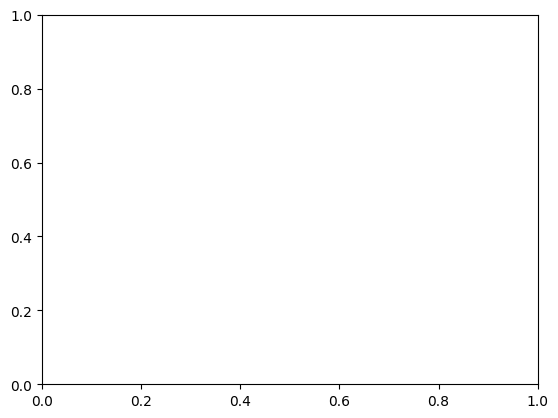

In [168]:
# Show predictions -- does not work if x and y are not the same size
Y_pred = fit_lin.predict(x)
plt.scatter(x, y)
plt.plot(x, Y_pred, color='red')
plt.show()

In [ ]:
#######################################################
## Multilevel model - relationships nested in countries
########################################################

In [ ]:
# Done for 2017 and up, as 2000-2016 has too many missings for reliable output. 
# As well as Nr of new EVs only became popular post-2017.

In [157]:
# As our data is nested in countries, we also obtain model results from a multilevel model with country as the 
# grouping variable

model_ML = smf.mixedlm("Emissions_norm ~ New_EVs_norm", df_test2, groups=df_test2["Country"])
#Fit the model
result_ML = model_ML.fit()
#Print model summary
print(result_ML.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Emissions_norm
No. Observations: 203     Method:             REML          
No. Groups:       29      Scale:              0.0102        
Min. group size:  7       Log-Likelihood:     135.4473      
Max. group size:  7       Converged:          Yes           
Mean group size:  7.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.815     0.027  30.245  0.000   0.762   0.867
New_EVs_norm  -0.598     0.082  -7.279  0.000  -0.759  -0.437
Group Var      0.019     0.059                               



In [171]:
# Adding year IMAXIMUM LIKELIHOOD REGRESSION RESULTS FAIL -- THIS IS PROBABLY NOT A GOOD IDEA

model2 = smf.mixedlm("New_EVs_norm ~ New_EVs_norm + Year_norm", df_test2, groups=df_test2["Country"])
#Fit the model
result2 = model2.fit()
#Print model summary
print(result2.summary())

c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir


                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     New_EVs_norm
No. Observations:     203         Method:                 REML        
No. Groups:           29          Scale:                  0.0000      
Min. group size:      7           Log-Likelihood:         inf         
Max. group size:      7           Converged:              Yes         
Mean group size:      7.0                                             
----------------------------------------------------------------------
             Coef.  Std.Err.           z           P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept     0.000    0.000                 0.000 1.000 -0.000  0.000
New_EVs_norm  1.000    0.000 32357963493683384.000 0.000  1.000  1.000
Year_norm    -0.000    0.000                -1.540 0.123 -0.000  0.000
Group Var     0.000                                                   



c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Universiteit Utrecht - Python and SQL\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bo